In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Define the Convolutional Neural Network Architecture

In [3]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

## Load Data

In [4]:
batch_size = 64

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
images_batch, labels_batch = next(iter(train_loader))


In [9]:
images_batch.shape

torch.Size([64, 1, 28, 28])

In [11]:
images_batch[0,:,:,:].squeeze().shape

torch.Size([28, 28])

In [8]:
labels_batch

tensor([9, 4, 3, 8, 9, 6, 1, 3, 7, 0, 2, 8, 9, 2, 4, 7, 0, 3, 0, 3, 2, 9, 3, 2,
        6, 7, 6, 8, 9, 9, 5, 5, 0, 8, 8, 7, 2, 8, 3, 2, 8, 1, 4, 3, 8, 7, 0, 9,
        3, 0, 4, 6, 3, 4, 0, 4, 5, 7, 2, 3, 3, 7, 0, 2])

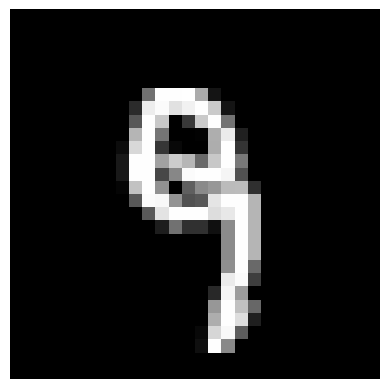

In [22]:
import matplotlib.pyplot as plt

b = images_batch[4,:,:,:].squeeze().numpy()
plt.imshow(b, cmap='gray')
plt.axis('off')
plt.show()

## Set up Device and Hyperparameters

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_size = 784  # 28x28 pixels (not directly used in CNN)
num_classes = 10  # digits 0-9
learning_rate = 0.001
num_epochs = 10  # Reduced for demonstration purposes

## Initialize the Network

In [16]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

## Define Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train the Network

In [19]:
for epoch in range(5):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    #for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
    for data, targets in tqdm(train_loader):
        # Move data and targets to the device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Optimization step: update the model parameters
        optimizer.step()

Epoch [1/10]


100%|██████████| 938/938 [00:13<00:00, 68.22it/s]


Epoch [2/10]


100%|██████████| 938/938 [00:13<00:00, 69.71it/s]


Epoch [3/10]


100%|██████████| 938/938 [00:13<00:00, 70.21it/s]


Epoch [4/10]


100%|██████████| 938/938 [00:13<00:00, 71.46it/s]


Epoch [5/10]


100%|██████████| 938/938 [00:13<00:00, 71.65it/s]


In [29]:
model.eval()

output = model(images_batch[0,:,:,:].unsqueeze(0))

In [32]:
print(output.max(1))
print()
print(labels_batch[0])

torch.return_types.max(
values=tensor([7.2867], grad_fn=<MaxBackward0>),
indices=tensor([9]))

tensor(9)


### Check Accuracy

In [33]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.

    Parameters:
        loader: DataLoader
            The DataLoader for the dataset to check accuracy on.
        model: nn.Module
            The neural network model.
    """
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    
    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 59332/60000 with accuracy 98.89%
Checking accuracy on test data
Got 9851/10000 with accuracy 98.51%


# Dataset and dataloader

In [34]:
import torch
from torch.utils.data import Dataset, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [35]:
type(test_data)

torchvision.datasets.mnist.FashionMNIST

AttributeError: 'int' object has no attribute 'numpy'

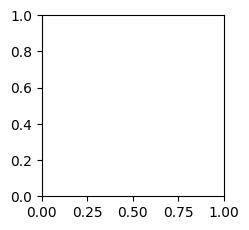

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [39]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


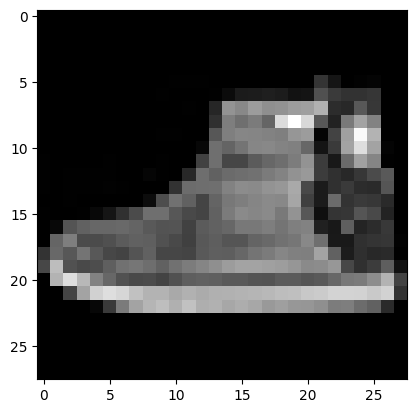

Label: Ankle Boot


In [51]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
lb = int(label.numpy())
print(f"Label: {labels_map[lb]}")

### Work on custom dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

In [ ]:
from glob import glob

folder_content = glob("Data/D_and_C/train/*.jpg")

In [53]:
folder_content[0:5]

['Data/D_and_C/train/dog.8011.jpg',
 'Data/D_and_C/train/cat.5077.jpg',
 'Data/D_and_C/train/dog.7322.jpg',
 'Data/D_and_C/train/cat.2718.jpg',
 'Data/D_and_C/train/cat.10151.jpg']

In [58]:
folder_content[0].split("/")[-1].split(".")[0]

'dog'

In [ ]:

folder_content[0].split("/")[-1].split(".")

In [76]:
paths = []
labels = []
for item in folder_content:
    item_split = item.split("/")[-1].split(".")[0]
    paths.append(item)
    if item_split == 'dog':
        labels.append(0)
    if item_split == 'cat':
        labels.append(1)


In [62]:
print(labels[0:5])
print(paths[0:5])

[0, 1, 0, 1, 1]
['Data/D_and_C/train/dog.8011.jpg', 'Data/D_and_C/train/cat.5077.jpg', 'Data/D_and_C/train/dog.7322.jpg', 'Data/D_and_C/train/cat.2718.jpg', 'Data/D_and_C/train/cat.10151.jpg']


In [81]:
i=13
print(labels[i], paths[i])

0 Data/D_and_C/train/dog.3144.jpg


In [93]:
#import os
#import pandas as pd
#from torchvision.io import decode_image
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.img_labels = labels
        self.img_dir = paths
        self.transform = transform

    def __len__(self):
        return 1000 #len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir[idx]}"
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.img_labels[idx]))
        if self.transform:
            image = self.transform(image)
        return image, label

In [94]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

c_and_d_dataset = CustomImageDataset(paths, labels, transform=transform)
c_and_d_dataloader = DataLoader(c_and_d_dataset, batch_size=64, shuffle=True)

In [95]:
c_and_d_dataset.__len__()
img, lb = c_and_d_dataset.__getitem__(45)

In [96]:
lb

tensor(1)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,          # 20% test set
    stratify=labels,        # Keeps label distribution balanced
    random_state=42         # For reproducibility
)

In [ ]:
def getTransformer(transform_resize, transform_crop, transform_normalize_mean, transform_normalize_var):

    transform = transforms.Compose(
            [
                transforms.Resize(transform_resize),
                transforms.RandomCrop(transform_crop),
                transforms.RandomRotation(90),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(transform_normalize_mean, transform_normalize_var),
            ]
        )

    return transform

In [97]:
images_batch, labels_batch = next(iter(c_and_d_dataloader))

print(images_batch.shape, labels_batch)


torch.Size([64, 3, 224, 224]) tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a simple CNN for binary classification
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),  # Assumes input images are resized to 224x224
            nn.ReLU(),
            nn.Linear(128, 1)  # Output single logit for binary classification
        )

    def forward(self, x):
        return self.net(x)

In [98]:
def train_model(model, dataloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # labels: [batch_size, 1]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")




In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BinaryCNN().to(device)
model = VGG16().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming train_loader is already defined
train_model(model, c_and_d_dataloader, criterion, optimizer, device, epochs=15)

 19%|█▉        | 3/16 [09:20<40:27, 186.73s/it]


KeyboardInterrupt: 

Have a loot at possible random transforamtion

In [101]:
model

BinaryCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100352, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Try to visualize the features map

In [122]:
images_batch, ___ = next(iter(c_and_d_dataloader))

activation = {}
def hook_fn(module, input, output):
    activation['conv_output'] = output.detach()

hook = model.net[5].register_forward_hook(hook_fn)

# Forward pass
#input_image = torch.randn(1, 3, 224, 224)

print(images_batch.shape)
input_image = images_batch[0,:,:,:].unsqueeze(0)
with torch.no_grad():
    _ = model(input_image)

# Now, activation['conv_output'] contains the output of the conv layer
print("Output shape of hooked layer:", activation['conv_output'].shape)

# Don't forget to remove the hook when done
hook.remove()

a = activation['conv_output']
type(a)

torch.Size([64, 3, 224, 224])
Output shape of hooked layer: torch.Size([1, 32, 56, 56])


torch.Tensor

(56, 56)


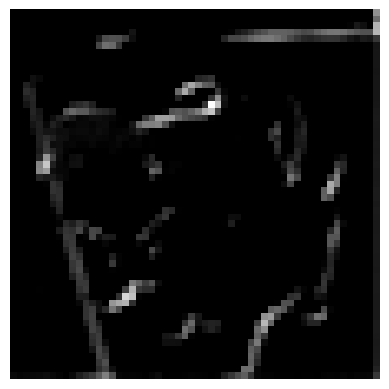

In [127]:
import matplotlib.pyplot as plt

b = a[:,14,:,:].squeeze().numpy()
print(b.shape)
plt.imshow(b, cmap='gray')
plt.axis('off')
plt.show()

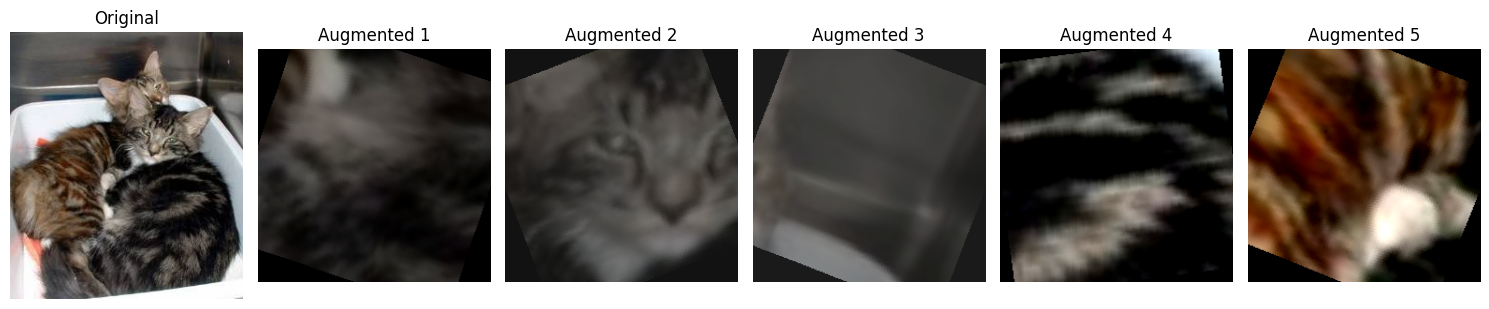

In [136]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

# Load a sample image
image_path = 'Data/D_and_C/train/cat.12447.jpg'  
image = Image.open(image_path).convert("RGB")

# Define random transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop((50,50)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor()
])

# Apply transformation multiple times to visualize the randomness
n_samples = 5
fig, axes = plt.subplots(1, n_samples + 1, figsize=(15, 5))

# Show original
axes[0].imshow(image)
axes[0].set_title('Original')
axes[0].axis('off')

# Show transformed samples
for i in range(n_samples):
    transformed_img = transform(image)
    # Convert tensor to PIL image for plotting
    axes[i+1].imshow(transformed_img.permute(1, 2, 0))  # Channel xHxW -> HxWx Cannel
    axes[i+1].set_title(f'Augmented {i+1}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

### Try to reimplement with 

In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,          # 20% test set
    stratify=labels,        # Keeps label distribution balanced
    random_state=42        
)

## VGG16 Test a well known model

In [137]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out